# Data Generator Tutorial

This is a tutorial on how to use this data generator. We're using a small example dataset that comes with this repository.

The generator can handle all sorts of annotation formats, but for this tutorial our example dataset will be a tiny subset (8 images) of the Pascal VOC 2007 dataset.

It is generally not necessary that ground truth annotations are available for the dataset, the generator can also load and generate batches of only images without any annotations, but for the purpose of this tutorial we'll assume that we do have annotations.

In the case of a dataset without annotations, for example a test dataset for a competition for which no ground truth is publicly available, everything explained here works just the same, the only difference being that there are no annotations.

Even though this tutorial explains a lot of important aspects about this data generator, it goes without saying that you should also read the documentation of all the relevant classes and functions so that you understand what all the parameters do.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from bounding_box_utils.bounding_box_utils import iou

from object_detection_2d_data_generator import DataGenerator
from transformations.object_detection_2d_patch_sampling_ops import *
from transformations.object_detection_2d_geometric_ops import *
from transformations.object_detection_2d_photometric_ops import *
from transformations.object_detection_2d_image_boxes_validation_utils import *
from data_augmentation_chains.data_augmentation_chain_original_ssd import *

%matplotlib inline

## 0. Contents

The tutorial consists of the following sections:
1. Basic Usage - this is probably all you need to know for most use cases
2. More Complex Processing Chains
3. Using a Label Encoder
4. Creating Your Own Parser Methods

## 1. Basic Usage

This section describes the basic usage of the data generator. This means:

1. Instantiating a `DataGenerator` object
2. Setting a dataset and parsing its annotations
3. Defining some image transformations for pre-processing and/or data augmentation
4. Generating mini batches

The data generator has more features and capabilities than are shown here, and some advanced topics are discussed in subsequent sections of this tutorial, while others lie beyond its scope.

### 1.1. Create a `DataGenerator` object

First, we'll create a `DataGenerator` object.

The constructor takes a bunch of optional arguments, but the only relevant one in this case is the `labels_output_format` argument. When the generator generates mini batches of images and annotations, a bounding box always consists of five elements: An ID for the class of the object that is enclosed by the bounding box and four coordinates that define the bounding box. The `labels_output_format` argument determines the order of these five elements in the generated annotations. It defaults to `('class_id', 'xmin', 'ymin', 'xmax', 'ymax')`, meaning the first element of a bounding box is the class ID (which will always be a positive integer), followed by the top left ('xmin', 'ymin') and bottom right ('xmax', 'ymax') corners of the bounding box. If you need the generator to generate the annotations in a different order, just pass a tuple with the order you need.

For details on the other arguments of the constructor, please refer to the documentation, but they are not relevant for this basic usage example.

In [2]:
dataset = DataGenerator(labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))

### 1.2. Set a dataset and parse annotations

This is where you actually tell the generator what your dataset is and where you parse its annotations (if there are any). Parsing the annotations just means that the generator will read the annotations from XML, JSON, CSV or whatever files your annotations are in and store them in a long list that it keeps in memory.

The data generator provides three such parser methods:
1. `parse_csv()`: This one is for datasets where you have a folder that contains all your images and a CSV file that contains the annotations for all the images. This parser is fairly versatile with regard to the layout of the CSV file: You can tell it what columns of the CSV file contain what information. For more details on this parser, please refer to its documentation.
2. `parse_json()`: This one is for datasets in the MS COCO format. The images and annotations of your dataset don't necessarily need to be all in one directory, a point that will be illustrated below. For more details on this parser, please refer to its documentation.
3. `parse_xml()`: This one is for datasets in the Pascal VOC format, and this is the parser we'll be using for this tuturial to parse our example dataset. As with the JSON parser, the images and annotations of your dataset don't necessarily need to be all in one directory.

If your dataset is in a format that is not compatible with any of these parser methods, you could add your own custom parser method and still use this generator. One of the advanced sections further below explains how to do this.

After this general intro, let's get back to our example dataset, which is in the Pascal VOC format.

The XML parser needs:
* `image_dirs`: a list of directories that contain the images of your dataset,
* `image_set_filenames`: a list of paths of image set files that define which images are to be included in the dataset, and
* `annotations_dirs` (optional): a list of directories that contain the annotations XML files of your dataset.

If you are not familiar with this dataset format, please refer to the [official Pascal VOC documentation](http://host.robots.ox.ac.uk/pascal/VOC/). As for the second of these arguments above, an image set is simply a list of image IDs in form of a text file that determines which images belong to a dataset. Note that the three arguments above are not paths, but lists of paths. You can pass more than one image directory, more than one annotations directory, and more than one image set to the parser. The parser will then compose the joint dataset from all the sources you pass here. An important thing to note here is that all three of these lists need to have the same length, i.e. each image directory corresponds to its respective annotations directory and image set file. In the example below these lists will have only one element each.

Assuming that we have ground truth available (as always throughout this tutorial), the XML parser needs to know the names of the object classes that it needs to look for in the XML annotations files. It also needs to know to which integers to map these class names. For this purpose, we'll pass a `classes` list to the parser. This list contains the names of all the classes in the dataset and the indices of the class names within the list are the class IDs. In the example below where we are using a subset of the Pascal VOC dataset, we want the 'aeroplane' class to have class ID 1, the 'bicycle' class to have class ID 2, and so on. Often in object detection we reserve the class ID 0 for the background class, so we'll add one element arbitrarily named 'background' as the very first element of the list so that the IDs of the actual classes start at index 1. Of course the generator doesn't care which class names are mapped to which integer IDs, so this is completely up to you.

In [4]:
images_dir         = '/home/omr/Desktop/final_project/img/iii/'
annotations_dir  = '/home/omr/Desktop/final_project/img/aaa/'
image_set_filename = '/home/omr/Desktop/final_project/img/img.txt'
image_gen_dir = '/home/omr/Desktop/final_project/gen/'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['Iron_Man',
'Captain_America',
'Thor',
'Hulk',
'Black_Widow',
'Hawkeye',
'Rocket_Raccoon',
'Groot'
]


dataset.parse_xml(images_dirs=[images_dir],
                  image_set_filenames=[image_set_filename],
                  annotations_dirs=[annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

img.txt: 100%|██████████| 22/22 [00:00<00:00, 445.70it/s]


### 1.3. How the image transformations work

This is where the interesting stuff begins. One of the most import success factors of the training of an object detection model is good data augmentation. This is where most data generators that I was able to find fail: Most of them come with a hard-coded chain of image transformations, so if you want to change the order of the transformations, add a new transformation, etc., you're out of luck.

This image transformations in this data generator are not hard-coded. Instead, you provide the generator with a list of transformations that the generator will then apply in that order. These transformations are just objects that take an image and (optionally) ground truth annotations for that image and return the transformed image and (optionally) the transformed annotatations. Whatever happens inside these transformation objects is none of the generators concern, so this allows you to create arbitrary data augmentation chains. We'll see a few of examples below that showcase why this is great.

This data generator comes with a whole bunch of image transformations that you can use out of the box, and all transformations come in deterministic and random versions. Specifically, the following transformations are provided:
* Photometric transformations: Brightness, contrast, hue, saturation, gamma, channel order, and histogram equalization
* Geometric transformations: Translation, scaling, flipping, rotation, resizing, padding, cropping, and sampling patches according to arbitrary criteria
* Utility transformations: Color space conversion, data type conversion, and converting n-channel images to 3-channel images

You'll see many of these transformations in action below. I also encourage you to read the documenation of the transformations you want to use. For now, let's just define one simple transformation to illustrate a few things.

In [5]:
translate = Translate(dy=-0.2,
                      dx=0.3,
                      clip_boxes=False,
                      box_filter=None,
                      background=(0,0,0))

The transformation above instantiates a deterministic translation operation. It translates an image by 0.3 of its width to the right and by 0.2 of its height upward. Don't worry about the other arguments yet. This object is callable, which allows the generator to apply it to the images and annotations of a batch. Don't worry about the `generate()` method in the next code cell yet, I'll explain it further down, for now we'll just quickly generate a batch to display a transformed image.

In [6]:
batch_size = 1

data_generator = dataset.generate(batch_size=batch_size,
                                  shuffle=False,
                                  transformations=[translate],
                                  label_encoder=None,
                                  returns={'processed_images',
                                           'processed_labels',
                                           'filenames',
                                           'original_images',
                                           'original_labels'},
                                  keep_images_without_gt=False)

In [7]:
processed_images, processed_annotations, filenames, original_images, original_annotations = next(data_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Original ground truth boxes:\n")
print(np.array(original_annotations[i]))

Image: /home/omr/Desktop/final_project/img/iii/00.jpg

Original ground truth boxes:

[[  0 490 140 931 622]]


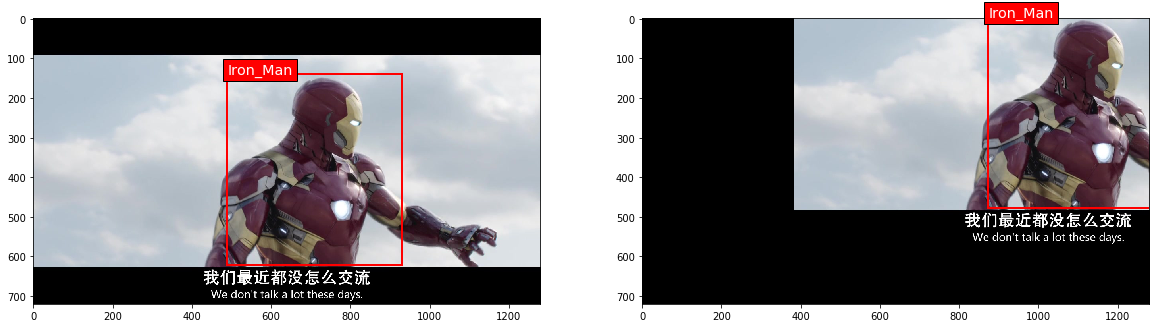

In [8]:
colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist() # Set the colors for the bounding boxes

fig, cell = plt.subplots(1, 2, figsize=(20,16))
cell[0].imshow(original_images[i])
cell[1].imshow(processed_images[i])

for box in original_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[0].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
for box in processed_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[1].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

So far so good, on the right you see the transformed image with the transformed bounding boxes drawn in.

First of all, the translated image explains the `background` argument of the `Translate` constructor above: It determines the RGB color of the background pixels that inevitably appear in the translated image. In our case they are black, but we could set any arbitrary color, for example the mean color of the dataset.

Secondly, the translated image explaines the `clip_boxes` argument of the `Translate` constructor above: The bounding box around the guy on the right is no longer entirely in the image, which raises the question: Should we clip the bounding box so that it ends where the image ends or should we accept that the bounding box now goes beyond the image boundaries? Even though you might intuitively say: "Clip the boxes, of course!", it's actually usually better not to clip the boxes, but I don't want to get into that. The point is that you have the choice.

Finally, and most importantly, the guy on the right is hardly in the image anymore. This raises the question: Do we actually want to keep this bounding box in the training data? Is it still a good training example for our model? Is it reasonable to expect the model to detect a person at the right border of the image if all you can see of that person is their arm? How much of an object must be visible in a transformed image such that it is worthwhile to keep that object's bounding box in the training data?

This is where the next aspect of the modular design of the data generator comes into play. You probably noticed the `box_filter` argument of the `Translate` constructor. For this argument, we can pass a `BoxFilter` object that will filter out invalid bounding boxes in the transformed image according to criteria that we define. If no box filter is passed to the `Translate` constructor, as is the case above, then guess what? The boxes won't be filtered.

Let's create a `BoxFilter` object:

In [9]:
box_filter = BoxFilter(overlap_criterion='area',
                       overlap_bounds=(0.4, 1.0))

This `BoxFilter` object can tell which bounding boxes meet the given overlap requirements with the image and which bounding boxes don't. The `overlap_criterion` determines how this overlap should be measured and the `bounds` determine within which range the overlap needs to be. In the example above, the overlap criterion is set to 'area', which means that a certain fraction of the area of a bounding box needs to overlap with the image. In our case, the `bounds` argument dictates that at least 0.4 and no more than 1.0 of the bounding box area needs to overlap with the image. There are two more overlap criteria to choose from: 'iou' and 'center_point'. 'center_point' determines a bounding box to be valid if its center point lies within the image (the `bounds` argument doesn't matter in this case). 'iou' determines a bounding box to be valid if the intersection over union (or Jaccard) similarity between the box and the image meets the given bounds.

`BoxFilter` can actually do a lot more than is described above: It can also check for and filter out degenerate boxes and it can filter out boxes that have less than a specified area. Both options are very useful but beyond the scope of this tutorial. The `BoxFilter` documentation contains all relevant details.

Let's pass this box filter to the `Translate` constructor and see what it does:

In [10]:
translate2 = Translate(dy=-0.2,
                       dx=0.3,
                       clip_boxes=False,
                       box_filter=box_filter,
                       background=(0,0,0))

Once again, let's generate a batch and display the image.

In [11]:
batch_size = 1

data_generator = dataset.generate(batch_size=batch_size,
                                  shuffle=False,
                                  transformations=[translate2],
                                  label_encoder=None,
                                  returns={'processed_images',
                                           'processed_labels',
                                           'filenames',
                                           'original_images',
                                           'original_labels'},
                                  keep_images_without_gt=False)

In [12]:
processed_images, processed_annotations, filenames, original_images, original_annotations = next(data_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Original ground truth boxes:\n")
print(np.array(original_annotations[i]))

Image: /home/omr/Desktop/final_project/img/iii/00.jpg

Original ground truth boxes:

[[  0 490 140 931 622]]


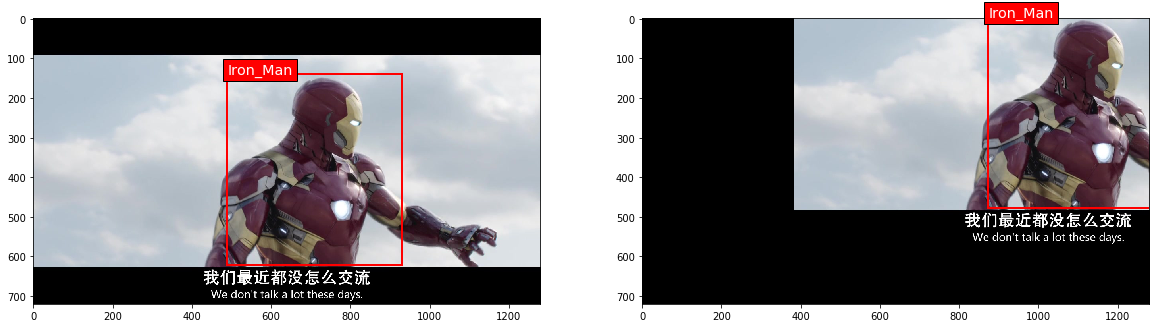

In [13]:
colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist() # Set the colors for the bounding boxes

fig, cell = plt.subplots(1, 2, figsize=(20,16))
cell[0].imshow(original_images[i])
cell[1].imshow(processed_images[i])

for box in original_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[0].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
for box in processed_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[1].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

Ah! The bounding box around the right guy is no longer part of the annotations of the translated image because less than 0.4 of its area overlap with the image.

As is the case with all image transformations, the `Translate` transformation also has a random version, `RandomTranslate`. It introduces a few new parameters that many of the random transformations share. Let's take a look.

In [14]:
random_translate = RandomTranslate(dy_minmax=(0.03,0.3),
                                   dx_minmax=(0.03,0.3),
                                   prob=0.5,
                                   clip_boxes=False,
                                   box_filter=None,
                                   image_validator=None,
                                   n_trials_max=3)

As you can probably guess, the first two arguments specify the range from which a random translation factor will be randomly picked.

The third argument, `prob`, determines the probability with which the transformation will actually be applied to an image. In this case, only every second image will be translated on average, the other images will just be returned unaltered.

An important argument here is the `image_validator` argument. It takes an `ImageValidator` object. Since the image is being transformed randomly, we cannot be certain that the result of the transformation is desirable. In the image above, imagine the guy on the bike wasn't there. Then the image before the translation would only contain one object, the guy who stretches out his arms. Now, if a random translation yielded a result as above, then the image after the translation wouldn't contain any bounding boxes at all. We probably wouldn't want a training image that contains zero ground truth bounding boxes. That's what the `ImageValidator` object will be for: Much like how the `BoxFilter` determines which boxes are valid, the `ImageValidator` determines whether or not the result of an image transformation is valid according to criteria we define. We'll look into this in the next code cell. If no image validator is passed, as is the case in the code cell above, then any transformation result will be accepted.

The other important argument in conjunction with the `image_validator` argument is `n_trials_max`. It determines how many times at most the operation will try to produce a transformed image that meets the requirements dictated by the `ImageValidator`. If no valid transformed image could be produced after `n_trials_max` trials, then the original, unaltered image will be returned instead.

Let's create an `ImageValidator` object:

In [15]:
image_validator = ImageValidator(overlap_criterion='area',
                                 bounds=(0.3, 1.0),
                                 n_boxes_min=1)

The first two arguments here are the same as for `BoxFilter`. The third argument, `n_boxes_min`, determines the minimum number of bounding boxes that need to meet the criteria in order for the transformed image to be accepted as valid. This particular `ImageValidator` object would accept a transformed image if at least one bounding box would have at least 0.3 of its area overlap with the transformed image.

Note that in the arguments of the `RandomTranslate` constructor, you pass both a `BoxFilter` and an `ImageValidator` object. This means the criteria by which the transformation decides which boxes to keep are not necessarily the same criteria as those by which the transformation decides whether a given transformed image is valid. This provides great flexibility, and in one of the next sections we'll see an example of a very successful object detection model that actually uses different criteria for box filtering and image validation in its data augmentation pipeline.

Of course `BoxFilter` and `ImageValidator` objects aren't relevant for all image transformations. For example, if you flip an image, the flipped image is guaranteed to fully contain all bounding boxes just as before the flip. Or if you apply photometric transformations to an image, its annotations don't even change at all. These transformations don't take `BoxFilter` or `ImageValidator` objects in their arguments because there is nothing to filter or validate.

### 1.4. Put together a data augmentation pipeline

The previous section was just foreplay to introduce you to how image transformations generally work by means of a concrete example.

Now we'll put together a real pipeline for image pre-processing and data augmentation. We'll first create the objects for all the transformations and then well arrange them in a list to produce our processing chain.

In [16]:
# Utility transformations
convert_to_3_channels = ConvertTo3Channels() # Make sure all images end up having 3 channels.
convert_RGB_to_HSV    = ConvertColor(current='RGB', to='HSV')
convert_HSV_to_RGB    = ConvertColor(current='HSV', to='RGB')
convert_to_float32    = ConvertDataType(to='float32')
convert_to_uint8      = ConvertDataType(to='uint8')
resize                = Resize(height=300, width=300)

# Photometric transformations
random_brightness     = RandomBrightness(lower=-48, upper=48, prob=0.5)
random_contrast       = RandomContrast(lower=0.5, upper=1.5, prob=0.5)
random_saturation     = RandomSaturation(lower=0.5, upper=1.5, prob=0.5)
random_hue            = RandomHue(max_delta=18, prob=0.5)

# Geometric transformations
random_flip           = RandomFlip(dim='horizontal', prob=0.5)
patch_coord_generator = PatchCoordinateGenerator(must_match='w_ar',
                                                 min_scale=0.3,
                                                 max_scale=2.0,
                                                 scale_uniformly=False,
                                                 min_aspect_ratio = 0.5,
                                                 max_aspect_ratio = 2.0)
random_patch          = RandomPatch(patch_coord_generator=patch_coord_generator,
                                    box_filter=box_filter,
                                    image_validator=image_validator,
                                    n_trials_max=10,
                                    clip_boxes=False,
                                    prob=1.0,
                                    can_fail=False)

# Define the processing chain
data_augmentation = [convert_to_3_channels,
                     convert_to_float32,
                     random_brightness,
                     random_contrast,
                     convert_to_uint8,
                     convert_RGB_to_HSV,
                     convert_to_float32,
                     random_saturation,
                     random_hue,
                     convert_to_uint8,
                     convert_HSV_to_RGB,
                     random_patch,
                     random_flip,
                     resize]

There's a lot happening in the code cell above. Let's break it down.

First, we're defining a bunch of utility transformations:
* `ConvertTo3Channels`: Regardless of which deep learning framework you're using, images within the same batch must always have the same shape, which means they must also have the same number of color channels. Some datasets contain a mix of 3-channel (e.g. RGB) and single-channel images. Some datasets might even contain a mix of 3-channel, 1-channel, and 4-channel images. This transformations converts any image to 3 channels if it isn't a 3-channel image already. This is basically just a safety transformation that we will put at the very beginning of our processing chain. If we were 100% certain that all images in our dataset had the same number of channels, we could omit this safety transformation, but often you aren't 100% certain.
* `ConvertColor`: Some of the photometric transformations require the images to be in RGB and others in HSV, so we need color space transformations to convert accordingly between these two color spaces.
* `ConvertDataType`: Some of the photometric transformations require the images to be in `float32` format, while some OpenCV functions like `cvtColor()` require the images to be in `uint8` format, so we need transformations to convert between those two datatypes.
* `Resize`: As mentioned above, images within the same batch must always have the same shape. The images in the Pascal VOC datasets have varying sizes, therefore we need to resize them to a fixed size. In our particular processing chain, this is not directly the reason why we need a resizing transformation though. We're sampling random patches of varying sizes and aspect ratios from the input images, so we need to resize those randomly sampled patches to a fixed size at the end. This resizing of images of varying aspect ratios has an intended side effect: It introduces random deformation. Some images will be stretched in one dimension and compressed in the other, etc. As long as the deformed objects are still recognizable, slight deformations are usually highly desirable in order to improve a model's ability to generalize.

Next, we're defining a bunch of photometric distortions:
* `RandomBrightness`: Randomly increases or reduces the brightness of images.
* `RandomContrast`: Randomly increases or reduces the contrast of images.
* `RandomSaturation`: Randomly increases or reduces the saturation of images.
* `RandomHue`: Randomly changes the hue of images.

Next, we're defining a few geometric transformations:
* `RandomFlip`: Randomly flips images, in our case horizontally.
* `RandomPatch`: Samples random patches from the input images according to the specifications defined in the `PatchCoordinateGenerator` (see below). Note that the `RandomPatch` transformation uses the box filter and image validator we defined earlier.
* `PatchCoordinateGenerator`: This is not a transformation. It's an object that generates random coordinates for patches according to specified criteria, and it is being passed to the `RandomPatch` constructor. In our example, the generated patches have an aspect ratio between 0.5 and 2.0 and their width is between 0.3 and 2.0 of the width of the input image. Note that this means that the generated patches can be larger than the input image in one or both spatial dimensions. This has a scaling effect: Patches that are smaller than the respective input image act as a "zoom-in" operation, while patches that are larger than the respective input image act as a "zoom-out" operation. In general, this `PatchCoordinateGenerator` makes the `RandomPatch` transformation ultimately flexible because it can produce random patches that meet any conceivable criteria.

Finally, we're arranging all of these transformations in an order that makes sense. This is certainly not the only order that would make sense, but it is one sensible order.

Let's look at the results of our data augmentation pipeline. For one last time, don't worry about the `generate()` method in the next code cell, we'll get to that in a moment. For now we just quickly want to flip through a few transformed images to visualize what our processing chain does.

In [17]:
batch_size = 1

data_generator = dataset.generate(batch_size=batch_size,
                                  shuffle=False,
                                  transformations=data_augmentation,
                                  label_encoder=None,
                                  returns={'processed_images',
                                           'processed_labels',
                                           'filenames',
                                           'original_images',
                                           'original_labels'},
                                  keep_images_without_gt=False)

Execute the next two cells multiple times to produce a few transformed images. Our data augmentation chain produces quite a range of variation in our data.

In [18]:
processed_images, processed_annotations, filenames, original_images, original_annotations = next(data_generator)

i = 0 # Which batch item to look at


print("Image:", filenames[i])
print()
print("Original ground truth boxes:\n")
print(np.array(original_annotations[i]))

Image: /home/omr/Desktop/final_project/img/iii/00.jpg

Original ground truth boxes:

[[  0 490 140 931 622]]


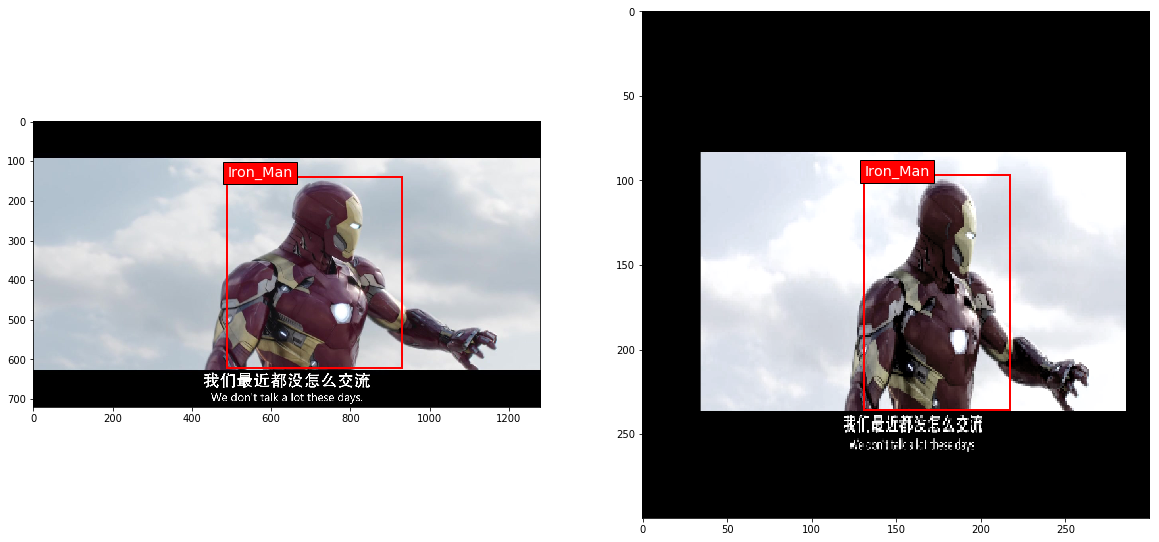

In [19]:
colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist() # Set the colors for the bounding boxes

fig, cell = plt.subplots(1, 2, figsize=(20,16))
cell[0].imshow(original_images[i])
cell[1].imshow(processed_images[i])

for box in original_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[0].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
for box in processed_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[1].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

### 1.5. Generate mini batches

In the previous two sections I had completely skipped the method that produces the actual generator, `generate()`. We'll go over it now.

You've already seen above how it is being called: In our example, `dataset` is a `DataGenerator` object and we called this object's `generate()` method to get `data_generator`, which is the actual generator function that can then be iterated over by calling Python's `next()` function on it.

What we haven't talked about yet are its arguments. As always, I strongly encourage you to read the documentation, it explains all the arguments in detail. I'll still go over some of them here:

* `batch_size`: You probably guessed it, this determines the number of images per mini batch.
* `shuffle`: You can choose whether the generator should or should not shuffle the dataset. For the training of a model it's usually important to shuffle the dataset, but for the evaluation of the model, for example, shuffling is unnecessary. There may also be situations when you want to make predictions on images in a specific order.
* `transformations`: The previous two sections were all about this. This is a list of transformation objects like the ones we created above. Even if your processing chain consisted of only one single transformation object, you would still need to put it in a list. The transformations in this list will be executed in the given order. If you pass an empty list, no transformations will be applied to the images. A transformation can be any callable that takes an image and optionally annotations and also returns and image and, if given, annotations.
* `label_encoder`: Your object detection model may require the ground truth annotations to be in a specific format during the training. This is what this argument is for. Here you can pass an object that takes a list of the annotations for the whole mini batch and returns some transformed version of those annotations. Note that while the image transformation objects described above always take a single image and the annotations for that single image, a label encoder object must take a list of the annotations for the entire batch. One example for a label encoder will be shown in one of the subsequent sections.
* `returns`: This is a set of strings that defines what the generator should yield. You could choose to yield only the processed images, or the processed images and the processed annotations, or also the unprocessed original images, or whatever you need. Please refer to the documentation for a detailed explanation of all the possible returns. Note that this is a set, i.e. order does not matter. The generator yields its outputs in a fixed order, regardless of the order in which you arrange the strings in this set.
* `keep_images_without_gt`: If you set this argument to `False`, then images that don't contain any ground truth even **before** any transformations were applied are being removed from the batch right away. It does sometimes happen that datasets contain images that don't have any ground truth bounding boxes at all. This argument lets you decide whether you want to keep such images in the batch.

Another point worth mentioning is that the generator generates batches indefinitely. After a pass over the entire dataset it just starts over. If you have `shuffle` activated, it shuffles the dataset after each complete pass.

This is it for the basic usage part of the tutorial, the subsequent sections dive into more specific topics.

## 2. More Complex Processing Chains

In this section we'll briefly discuss the original data augmentation pipeline of the [Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) (SSD) model. You can find a Keras port of SSD that uses this very data generator [here](https://github.com/pierluigiferrari/ssd_keras).

SSD is an amazing object detection model for many reasons, and one reason why it was so successful is because its authors used a sophisticated data augmentation pipeline for their training. As they write in the paper, without this extensive data augmentation process the model couldn't have achieved the performance it has.

This data augmentation chain also showcases the unlimited flexibility of this data generator when it comes to image processing. Let's take a look:

In [21]:
ssd_data_augmentation = SSDDataAugmentation(img_height=300, img_width=300)

That's it, this object contains the entire pipeline. Let's pass it to the generator and check out the results. Note that `ssd_data_augmentation` is a single transformation object, not a list of transformation objects, therefore we need to put it inside a list when we pass it to the generator.

In [22]:
batch_size = 1

data_generator = dataset.generate(batch_size=batch_size,
                                  shuffle=False,
                                  transformations=[ssd_data_augmentation],
                                  label_encoder=None,
                                  returns={'processed_images',
                                           'processed_labels',
                                           'filenames',
                                           'original_images',
                                           'original_labels'},
                                  keep_images_without_gt=False)

In [23]:
processed_images, processed_annotations, filenames, original_images, original_annotations = next(data_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Original ground truth boxes:\n")
print(np.array(original_annotations[i]))

Image: /home/omr/Desktop/final_project/img/iii/00.jpg

Original ground truth boxes:

[[  0 490 140 931 622]]


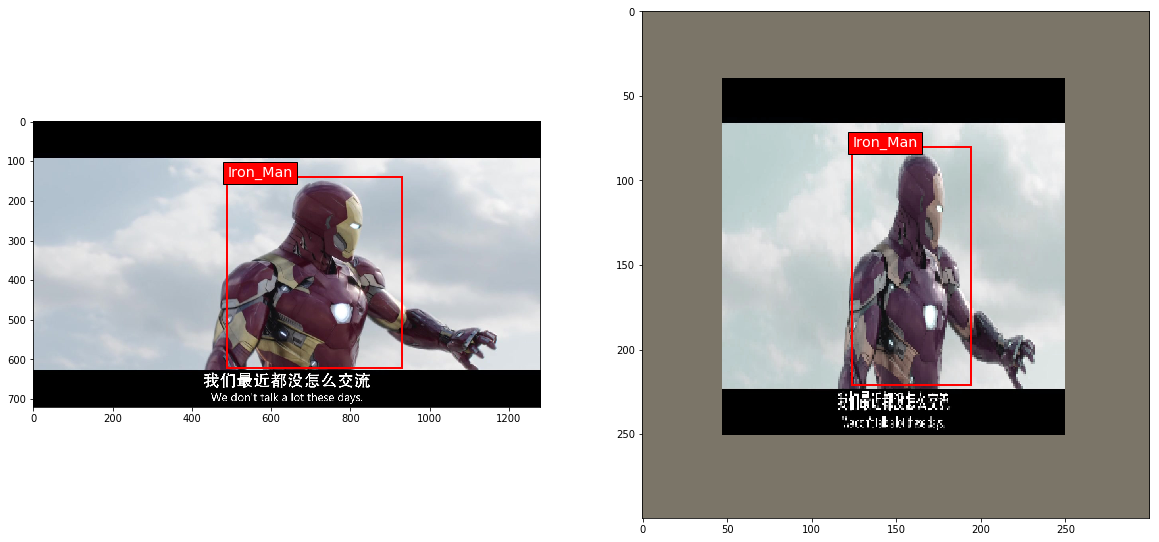

In [24]:
colors = plt.cm.hsv(np.linspace(0, 1, len(classes))).tolist() # Set the colors for the bounding boxes

fig, cell = plt.subplots(1, 2, figsize=(20,16))
cell[0].imshow(original_images[i])
cell[1].imshow(processed_images[i])

for box in original_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[0].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    
for box in processed_annotations[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    color = colors[int(box[0])]
    label = '{}'.format(classes[int(box[0])])
    cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    cell[1].text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

The point to note here is that you can put an arbitrarily complex image processing strategy into a single object an pass that to the generator.

I won't paste the code of the entire pipeline here, but take a look at it in [data_augmentation_chain_original_ssd.py](data_augmentation_chains/data_augmentation_chain_original_ssd.py), it's very instructive.

In particular, take a look at the code in the `SSDPhotometricDistortions` class. It uses the photometric distortions introduced above as its basic building blocks, but it creates two different sequences of transformations and each time it is being called, one of the two sequences is randomly chosen and applied. This can be very useful. You don't need to limit yourself to one single processing chain. You could have multiple parallel chains of transformations from which one is picked at random every time.

Another thing to note here that is also mentioned in the data augmentation section of the SSD paper is that the criterion by which a random crop is accepted as valid is not the same as the criterion by which bounding boxes are kept or dropped:

In [25]:
box_filter = BoxFilter(overlap_criterion='center_point')

image_validator = ImageValidator(overlap_criterion='iou', n_boxes_min=1)

In order for a crop to be valid, at least one ground truth bounding box needs to have a certain minimum IoU with the cropped image, but in order for a bounding box to be kept in the cropped image, its center point needs to lie within the cropped image boundaries.

Furthermore, the bounds that are set in the `ImageValidator` object are not constant. In the basic usage section above, we set the `bounds` argument in the `ImageValidator` and `BoxFilter` constructors by passing a tuple with a lower and upper bound, e.g. `(0.3, 1.0)`. In this case, however, instead of passing a tuple, we pass a `BoundGenerator` object for the `bounds` argument:

In [26]:
bound_generator = BoundGenerator(sample_space=((None, None),
                                               (0.1, None),
                                               (0.3, None),
                                               (0.5, None),
                                               (0.7, None),
                                               (0.9, None)),
                                 weights=None)

To be precise, this bound generator is not being passed to the `ImageValidator` constructor, but to the `RandomPatchInf` constructor, which manages the used bounds internally, but that's just a detail. The bound generator is a callable object that just outputs one element of its `sample_space` each time it is being called. In the example above, the sample space contains six tuples of bounds to chose from. `(None, None)` is equivalent to `(0.0, 1.0)`, meaning no bounds at all, since the IoU is always in `[0,1]`. As always, I encourage you to read the documentation for details.

This means that the requirements by which the `ImageValidator` decides whether a random crop is valid change randomly with each call. Sometimes, we are willing to accept a random crop if at least one bounding box has an IoU overlap of at least 0.1 with the cropped image, another time we may only accept it if the IoU overlap is at least 0.9, and yet another time we may accept any random crop result regardless of the IoU overlap with any of the ground truth boxes.

As a final side note, the fact that the original trained SSD models score highly on a number of academic reference datasets means that this particular data augmentation chain evidently works well, but if you look at it closely you will realize that it's not exactly efficient. In fact, the data augmentation chain introduced in the basic usage section above with a few small changes could probably yield almost the same results at a fraction of the computational complexity.

## 3. Using a Label Encoder

As explained in the basic usage section above, you can optionally pass a `label_encoder` to the `generater()` method. The internal structure of the `generate()` method is as follows: The images for the batch are being loaded, then the given image transformations (if any) are applied to each image and its respective annotations (if any) individually, and once this is done, if a `label_encoder` was given, then the list of annotations for all images in the batch will be passed to the encoder, which will then return some modified version of those annotations.

To make this concept more tangible, I'll once again use the [Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) (SSD) model as an example. Without going into great detail, suffice it to say that during the training of the model, SSD matches the ground truth boxes of every image in a batch to a huge tensor of thousands of so-called anchor (or default) boxes. This huge tensor represents the actual training targets for the model. Now, one possibility to implement SSD would be to have the data generator feed the non-encoded ground truth annotations to the model and the model does the matching and encoding internally. Another possibility would be to pass an encoder object to the data generator and have the data generator feed the encoded ground truth annotations to the model. The latter alternative is what [this](https://github.com/pierluigiferrari/ssd_keras) SSD implementation does, so if you'd like to see a concrete example, check out one of the training tutorials there.

## 4. Creating Your Own Parser Methods

If your dataset isn't compatible with any of the parser methods that come with this generator, you could choose to write your own parser method and add it. In most cases you could probably get away with making a few minor modifications to one of the existing parser methods, but in case you really need to write a new parser method from scratch, a brief introduction to the internal design of the data generator and the parser methods may be helpful.

If you take a look at the `DataGenerator` constructor, there are three members that are important:
* `filenames`
* `labels`
* `image_ids`

`filenames` is a list in which the data generator object stores the full paths of all images that belong to the dataset, e.g. "path/to/dataset/001934375.png". This means that the length of this list is the size of the dataset. The job of a parser method is to set this list. If you write your own parser method, you're completely free in its design, you only need to make sure that the full file paths to the images that are supposed to be in the dataset end up in this list. Important: Note that this list is supposed to contain only the paths to the images, not the images themselves.

`labels` is a list of the same length as `filenames` in which the data generator object stores the annotations for all images that belong to the dataset. It is set to `None` by default since ground truth isn't always available. Each element of this list must contain a list or (preferably) Numpy array that contains the annotations for the respective image. Once again, if you write your own parser method, all you have to make sure is that the ground truth for all the images ends up in this list. Or, of course, if there is no ground truth, just ignore this member.

`image_ids` is a list of the same length as `filenames` in which the data generator object stores the image IDs for all images that belong to the dataset. It is set to `None` by default since not all datasets use the concept of image IDs. Image IDs are positive integers by which every image in the dataset can be uniquely identified. Popular datasets like Pascal VOC or MS COCO use image IDs to relate images and annotations. If you want to store IDs for the images in your dataset, this list is where you put them. Otherwise your parser can just ignore this member.

To summarize: The only requirement for your parser method is to produce the `filenames` list and optionally the other two lists.